In [1]:
import rdflib
import numpy as np
import torch
from pykeen.triples import TriplesFactory
from pykeen.models.inductive import InductiveNodePieceGNN
from pykeen.losses import NSSALoss
from torch.optim import Adam
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation import SampledRankBasedEvaluator, RankBasedEvaluator
from pykeen.stoppers import EarlyStopper
from pykeen.predict import predict_target, predict_all
from pykeen.checkpoints import save_model

import torch.nn.functional as F
from modular_methods.similarity_utils import compute_cosine_similarity, match_entities
from modular_methods.graphToText_utils import get_literals_for_entities
from modular_methods.dedup_pipeline import deduplicate_graphs, save_matches
from modular_methods.output_utils import build_final_result

### ---- 1. Load RDF graphs ----

train_graph = rdflib.Graph()
test_combined = rdflib.Graph()

train_graph.parse("data/train_combined_NodePiece.ttl")
test_combined.parse("data/test_combined_NodePiece.ttl")

def graph_to_triples(g):
    return [
        (str(s), str(p), str(o))
        for s, p, o in g
        if isinstance(s, rdflib.URIRef) and isinstance(o, rdflib.URIRef)
    ]

train_triples = np.array(graph_to_triples(train_graph))
test_triples = np.array(graph_to_triples(test_combined))


d:\Program Files\Uni\Master Scriptie\Code Snippets\entity-deduplication-hack-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Extract unique relations from train and test triples
train_relations = set(train_triples[:, 1])
test_relations = set(test_triples[:, 1])

# Find common and unique relations
common_relations = train_relations & test_relations
train_only_relations = train_relations - test_relations
test_only_relations = test_relations - train_relations

print(f"Number of relations in train: {len(train_relations)}")
print(f"Number of relations in test: {len(test_relations)}")
print(f"Number of common relations: {len(common_relations)}")
print(f"Relations only in train: {train_only_relations}")
print(f"Relations only in test: {test_only_relations}")

Number of relations in train: 7
Number of relations in test: 6
Number of common relations: 6
Relations only in train: {'http://www.w3.org/2002/07/owl#sameAs'}
Relations only in test: set()


In [3]:
### ---- 3. Build TriplesFactory objects ----

tf_train = TriplesFactory.from_labeled_triples(train_triples, create_inverse_triples=True)
tf_test = TriplesFactory.from_labeled_triples(
    test_triples,
    relation_to_id=tf_train.relation_to_id,
    create_inverse_triples=True
)

inductive_inference, inductive_validation, inductive_testing = tf_test.split(ratios=(0.8, 0.1), random_state=69)

In [7]:
inductive_validation

TriplesFactory(num_entities=1563, num_relations=7, create_inverse_triples=False, num_triples=388)

In [15]:
### ---- 4. Train InductiveNodePieceGNN ----

model = InductiveNodePieceGNN(
    triples_factory=tf_train,
    inference_factory=inductive_inference,
    num_tokens=12,
    aggregation="mlp",
    embedding_dim=128,
    loss=NSSALoss(margin=15),
    random_seed=42,
    gnn_encoder=None,  # Use default GNN encoder
).to("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=0.0005)

training_loop = SLCWATrainingLoop(
    triples_factory=tf_train,
    model=model,
    optimizer=optimizer,
    mode="training"
)
valid_evaluator = SampledRankBasedEvaluator(
    mode ="validation",
    evaluation_factory=inductive_validation,
    additional_filter_triples=[inductive_inference.mapped_triples],
)

test_evaluator = SampledRankBasedEvaluator(
    mode="testing",
    evaluation_factory=inductive_testing,
    additional_filter_triples=[
        inductive_inference.mapped_triples,
    ],
)

early_stopper = EarlyStopper(
    model=model,
    training_triples_factory=tf_train,
    evaluation_triples_factory=inductive_validation,
    frequency=1,
    patience=2,  # Adjust patience as needed
    result_tracker=None,
    evaluation_batch_size=128,
    evaluator=valid_evaluator,
)

print("Training NodePiece...")
training_loop.train(
    triples_factory=tf_train,
    num_epochs=40)


# Save the trained model to a file
save_model(model, "nodepiece_gnn_trained.pt")
print("Model saved to nodepiece_gnn_trained.pt")

No symbolic computation of output shape.                       
No symbolic computation of output shape.              


Training NodePiece...


Training epochs on cpu: 100%|██████████| 40/40 [13:01<00:00, 19.53s/epoch, loss=0.231, prev_loss=0.218]

Model saved to nodepiece_gnn_trained.pt


In [ ]:
# Predict all tail candidates for all heads
all_predictions = predict_all(
    model=model,
    k=5,  # adjust as needed
    mode="testing",
    target="tail"
)

# Convert to dataframe
all_df = all_predictions.process(factory=inductive_inference)

predict is an expensive operation, involving 98,805,343 score evaluations.


<http://www.w3.org/2002/07/owl:sameAs

In [20]:
all_df.df['relation_label'].unique()

array(['https://schema.org/memberOf', 'https://schema.org/worksFor',
       'http://www.w3.org/2002/07/owl#sameAs',
       'https://schema.org/address',
       'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
       'https://schema.org/contactPoint',
       'https://schema.org/parentOrganization'], dtype=object)

In [ ]:
# Filter all_df for rows with the desired relation_label
sameas_df = all_df.df[all_df.df['relation_label'] == 'http://www.w3.org/2002/07/owl#sameAs']
sameas_df


,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
22696,1561,https://schema.org/Person,1,http://www.w3.org/2002/07/owl#sameAs,1179,http://example.org/Person/d309e0ab-6c1e-431b-9...,-2.598588
22697,1179,http://example.org/Person/d309e0ab-6c1e-431b-9...,1,http://www.w3.org/2002/07/owl#sameAs,1561,https://schema.org/Person,-2.598589
23416,1561,https://schema.org/Person,1,http://www.w3.org/2002/07/owl#sameAs,1000,http://example.org/Person/977e7120-ee1a-4c7b-a...,-2.635283
23417,1000,http://example.org/Person/977e7120-ee1a-4c7b-a...,1,http://www.w3.org/2002/07/owl#sameAs,1561,https://schema.org/Person,-2.635283
24556,1561,https://schema.org/Person,1,http://www.w3.org/2002/07/owl#sameAs,862,http://example.org/Person/6d543cd3-50a0-4273-a...,-2.672819
...,...,...,...,...,...,...,...
72171,1207,http://example.org/Person/d9941dd1-93d4-41de-8...,1,http://www.w3.org/2002/07/owl#sameAs,1561,https://schema.org/Person,-3.546039
72320,1030,http://example.org/Person/a3b0d6a0-95fc-4937-b...,1,http://www.w3.org/2002/07/owl#sameAs,1561,https://schema.org/Person,-3.548629
72321,1561,https://schema.org/Person,1,http://www.w3.org/2002/07/owl#sameAs,1030,http://example.org/Person/a3b0d6a0-95fc-4937-b...,-3.548629
72360,1139,http://example.org/Person/c6d10a37-5179-41b2-a...,1,http://www.w3.org/2002/07/owl#sameAs,1561,https://schema.org/Person,-3.549418


In [25]:
from pykeen.predict import predict_triples

# Generate candidate triples: all possible entity pairs
import itertools
entity_ids = list(inductive_inference.entity_to_id.keys())
candidate_triples = [
    (h, "http://www.w3.org/2002/07/owl#sameAs", t)
    for h, t in itertools.product(entity_ids, entity_ids)
    if h != t  # avoid trivial sameAs self-pairs
]

# Predict scores
predicted_sameas = predict_triples(
    model=model,
    mode="testing",
    triples=candidate_triples,
    triples_factory=inductive_inference
)

predicted_sameas

Using automatic batch size on device.type='cpu' can cause unexplained out-of-memory crashes. Therefore, we use a conservative small batch_size=32. Performance may be improved by explicitly specifying a larger batch size.
Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


ScorePack(result=tensor([[   0,    1,    1],
        [   0,    1,    2],
        [   0,    1,    3],
        ...,
        [1562,    1, 1559],
        [1562,    1, 1560],
        [1562,    1, 1561]]), scores=tensor([-46.7417, -33.2422, -46.7417,  ..., -29.3794, -23.1373, -36.7511]))

In [27]:
# Convert from IDs to readable labels
triple_predictions = predicted_sameas.process(factory=inductive_inference)

# Get Pandas DataFrame
df = triple_predictions.df

# Inspect top predictions
df_sorted = df.sort_values(by="score", ascending=False)
print(df_sorted.head(10))


         head_id                                         head_label  \
2439461     1561                          https://schema.org/Person   
1843158     1179  http://example.org/Person/d309e0ab-6c1e-431b-9...   
1563560     1000  http://example.org/Person/977e7120-ee1a-4c7b-a...   
2439282     1561                          https://schema.org/Person   
1348004      862  http://example.org/Person/6d543cd3-50a0-4273-a...   
2439144     1561                          https://schema.org/Person   
1825976     1168  http://example.org/Person/cf82c6f9-bbb8-4361-a...   
2439450     1561                          https://schema.org/Person   
2439608     1561                          https://schema.org/Person   
2072772     1326  http://example.org/Person/fe54c8ba-056e-4eec-a...   

         relation_id                        relation_label  tail_id  \
2439461            1  http://www.w3.org/2002/07/owl#sameAs     1179   
1843158            1  http://www.w3.org/2002/07/owl#sameAs     1561   
15635

In [ ]:
def get_base(label):
    # Extract base type after 'example.org/' and before next '/'
    parts = label.split('example.org/')
    if len(parts) > 1:
        base = parts[1].split('/')[0]
        return base
    return None

df['head_base'] = df['head_label'].apply(get_base)
df['tail_base'] = df['tail_label'].apply(get_base)
df_filtered = df[df['head_base'] == df['tail_base']].drop(columns=['head_base', 'tail_base'])

In [42]:
# Filter out rows where score is greater than -50
filtered_scores = df_filtered[df_filtered['score'] > -30]
filtered_scores.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
23,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,24,http://example.org/Address/1ae3237f-aa88-4965-...,-29.091862
24,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,25,http://example.org/Address/1ba43eaf-84f4-4346-...,-29.065649
25,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,26,http://example.org/Address/1c7bc6c8-d62f-4e8c-...,-26.688372
27,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,28,http://example.org/Address/21ab9e3d-fdf4-4f09-...,-27.908621
30,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,31,http://example.org/Address/25b09e48-1ca1-4fa7-...,-29.524300


In [43]:
filtered_scores.to_csv("predicted_sameas_sorted.csv", index=False)

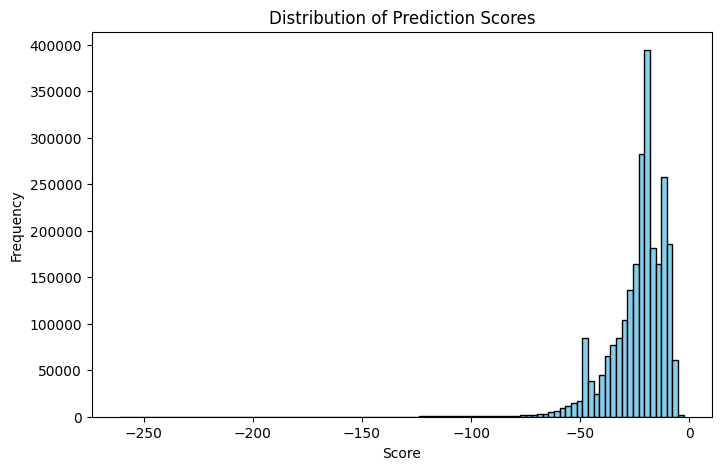

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['score'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Scores')
plt.show()

In [ ]:
result = test_evaluator.evaluate(
    model=model,
    mapped_triples=inductive_testing.mapped_triples,
    additional_filter_triples=[
    inductive_inference.mapped_triples,
    inductive_validation.mapped_triples
    ],
    batch_size=128 
    )




In [24]:
# For PyKEEN-like models
entity_embeddings = model.entity_representations[0]().detach().cpu().numpy()

# You can map from internal ID back to the original entity:
entity_id_to_label = tf_test.entity_id_to_label  # {id: 'entity_label'}
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# similarity_matrix[i, j] = similarity between entity i and entity j
similarity_matrix = cosine_similarity(entity_embeddings)

# Get entity labels for reference
entity_labels = [entity_id_to_label[i] for i in range(len(entity_id_to_label))]

entity_labels

['(000) 0035114',
 '(0028)-499243',
 '(003)-8016162',
 '(0053) 573452',
 '(007) 7131339',
 '(0089) 969726',
 '(0097)-410786',
 '(0110) 438805',
 '(0145) 901789',
 '(0150)-493331',
 '(0164) 630310',
 '(019) 0391103',
 '(022)-5402417',
 '(0263) 334006',
 '(029) 7657829',
 '(0329) 762146',
 '(033) 6184256',
 '(0338) 007752',
 '(035) 7800046',
 '(0359)-559906',
 '(045) 1726813',
 '(0508) 687889',
 '(0509) 558393',
 '(051) 3322487',
 '(059)-4724061',
 '(062)-7912560',
 '(063) 7805164',
 '(0670)-172009',
 '(0675) 727514',
 '(0714)-163115',
 '(076) 7970617',
 '(0806) 446410',
 '(0874)-206546',
 '(0875) 267737',
 '(0884) 832251',
 '(0904) 980790',
 '(0918)-558554',
 '(0921)-163416',
 '(0970)-341489',
 '(099) 9073342',
 '(0997)-391880',
 '(203)841-5253',
 '(218)919-2132x39644',
 '(274)327-9086',
 '(280)351-9921x4987',
 '(314)574-2692x96322',
 '(365)251-0888x770',
 '(392)794-5067x820',
 '(410)919-0400x6898',
 '(445)726-5176',
 '(463)307-4285',
 '(486)630-9419',
 '(591)818-7210x867',
 '(596)958-8

In [26]:
import pandas as pd
golden_df = pd.read_csv("data/test_golden_standard_high.csv")
golden_pairs = set(zip(golden_df['original_id'], golden_df['duplicate_id']))
# Optionally, add the reverse direction if your duplicates are symmetric
golden_pairs |= set((b, a) for (a, b) in golden_pairs)

In [ ]:


### ---- 5. Extract entity embeddings ----

def extract_embeddings(model, triples_factory, mode="training"):
    model.mode = mode
    emb_array = model.entity_representations[0]().detach().cpu().numpy()
    entities = list(triples_factory.entity_to_id.keys())
    return {e: emb_array[i] for i, e in enumerate(entities)}

main_embeddings = extract_embeddings(model, tf_train, mode="training")
test_embeddings = extract_embeddings(model, tf_test, mode="testing")

# Make sure only common entities/types are compared (as your pipeline does)
entity_ids1 = list(main_embeddings.keys())
entity_ids2 = list(test_embeddings.keys())

emb1 = torch.tensor([main_embeddings[e] for e in entity_ids1])
emb2 = torch.tensor([test_embeddings[e] for e in entity_ids2])

emb1 = F.normalize(emb1, p=2, dim=1)
emb2 = F.normalize(emb2, p=2, dim=1)

sim_matrix = compute_cosine_similarity(emb1, emb2)
matches = match_entities(sim_matrix, entity_ids1, entity_ids2, threshold=0.1, top_k=5)

# Literal-based filtering (as in your pipeline)
literals1 = get_literals_for_entities(train_graph, entity_ids1)
literals2 = get_literals_for_entities(test_combined, entity_ids2)
from modular_methods.similarity_utils import Levenshtein_filter
filtered_matches = Levenshtein_filter(matches, literals1, literals2, filter=False)

### ---- 7. Format and save results ----

final_result = build_final_result(
    filtered_matches,
    train_graph,
    test_combined,
    graph1_name="MainGraph",
    graph2_name="TestGraph"
)
save_matches(final_result, "NodePiece_dedup_results.json")
print(f"Saved results to NodePiece_dedup_results.json")

TypeError: 'NoneType' object is not iterable